In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
# from torchvision.datasets import MNIST
# from torchvision.transforms import ToTensor
import numpy as np

In [26]:
os.chdir("/home/vae")

## Dataloader

In [3]:
import os

import numpy as np
import torch
from torch.utils import data


class ImageDataLoader(data.Dataset):
    "My own Image Loader made to read .npy images"

    def __init__(self, directory, transform=None):

        self.directory = directory
        self.transform = transform
        self.file_names = [
            file
            for file in os.listdir(directory)
            if os.path.isfile(os.path.join(directory, file))
        ]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):

        img_path = os.path.join(self.directory, self.file_names[idx])
        image = np.load(img_path)
        image = image.astype(np.float32)

        if self.transform is not None:
            image = self.transform(image)

        image_labels = torch.zeros(image.shape[0])
        return image, image_labels


class ToTensorWithScaling:
    def __init__(self, min_val: float = 0.0, max_val: float = 1.0, eps: float = 1e-6):
        self.min_val = min_val
        self.max_val = max_val
        self.eps = eps

    def __call__(self, image: np.ndarray):
        image = torch.tensor(image, dtype=torch.float32)
        image = torch.permute(image, (2, 0, 1))

        # Get min and max values for every channel
        min_vals = image.amin(dim=(1, 2), keepdim=True)
        max_vals = image.amax(dim=(1, 2), keepdim=True)

        # [0, 1]
        image = (image - min_vals) / (max_vals - min_vals + self.eps)

        # [min_val, max_val]
        image = image * (self.max_val - self.min_val) + self.min_val

        # # rescale to 28 x 28
        # image = torch.nn.functional.interpolate(
        #     image.unsqueeze(0), (28, 28), mode="bilinear", align_corners=False
        # )
        # keep only 1 channel but keep the dimension
        # image = image.squeeze(0)[0].unsqueeze(0)

        return image

In [4]:
# import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 32

PATH_TEST_TYPICAL = "../dataset/test_typical"
PATH_TEST_NOVEL = "../dataset/test_novel/all"

RANDOM_SEED = 42

PATH_TRAIN = "../dataset/train_typical"
PATH_VALIDATION = "../dataset/validation_typical"

transform = ToTensorWithScaling(-1.0, 1.0)

# print(model_name, lr, epoch_number, device)

train_dataset = ImageDataLoader(PATH_TRAIN, transform=transform)
validation_dataset = ImageDataLoader(PATH_VALIDATION, transform=transform)

test_typical_dataset = ImageDataLoader(PATH_TEST_TYPICAL, transform=transform)
test_novel_dataset = ImageDataLoader(PATH_TEST_NOVEL, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size)

test_typical_loader = DataLoader(test_typical_dataset, batch_size=1)
test_novel_loader = DataLoader(test_novel_dataset, batch_size=1)

In [106]:
# verify that the data has no missing value
for i, (image, label) in enumerate(train_loader):
    if torch.isnan(image).any():
        print("Found missing value")
        break

# verify that data is in the correct range
for i, (image, label) in enumerate(train_loader):
    if torch.any(image < 0) or torch.any(image > 1.0):
        print("Found value outside of [0, 1]")
        break

## VAE Model definition

In [13]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import torch.nn as nn
import torch.nn.functional as F

pyro.enable_validation(False)

class VEncoder(nn.Module):
    """Encoder for VAE."""

    def __init__(
        self,
        n_input_features: int,
        n_hidden_neurons: int,
        n_latent_features: int,
    ):
        """
        :param n_input_features: number of input features (28 x 28 = 784 for MNIST)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_latent_features: size of the latent vector
        """
        super().__init__()
        self.input_to_hidden = nn.Linear(n_input_features, n_hidden_neurons)
        self.hidden_to_mu = nn.Linear(n_hidden_neurons, n_latent_features)
        self.hidden_to_sigma = nn.Linear(n_hidden_neurons, n_latent_features)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Encode data to gaussian distribution params."""
        x = F.relu(self.input_to_hidden(x))
        z_loc = self.hidden_to_mu(x)
        z_scale = self.hidden_to_sigma(x).exp()
        return z_loc, z_scale

class VDecoder(nn.Module):
    """Decoder for VAE."""

    def __init__(
        self,
        n_latent_features: int,
        n_hidden_neurons: int,
        n_output_features: int,
    ):
        """
        :param n_latent_features: number of latent features (same as in Encoder)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_output_features: size of the output vector (28 x 28 = 784 for MNIST)
        """
        super().__init__()
        self.latent_to_hidden = nn.Linear(n_latent_features, n_hidden_neurons)
        self.hidden_to_output = nn.Linear(n_hidden_neurons, n_output_features)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent vector to image."""
        r = F.relu(self.latent_to_hidden(z))
        r = torch.sigmoid(self.hidden_to_output(r))
        return r

class BaseAutoEncoder(nn.Module):
    """Base AutoEncoder module class."""

    def __init__(self, encoder: nn.Module, decoder: nn.Module, n_latent_features: int):
        """
        :param encoder: encoder network
        :param decoder: decoder network
        :param n_latent_features: number of latent features in the AE
        """
        super().__init__()
        self.n_latent_features: int = n_latent_features
        self.encoder: nn.Module = encoder
        self.decoder: nn.Module = decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward function for mapping input to output."""
        z = self.encoder_forward(x)
        return self.decoder_forward(z)

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network.

        takes: tensor of shape [batch_size x input_flattened_size] (flattened input)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """
        raise NotImplementedError()

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network.

        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x output_flattened_size] (flattened output)
        """
        raise NotImplementedError()

class VariationalAutoencoder(BaseAutoEncoder):
    """Variational Auto Encoder model."""

    def __init__(
        self,
        n_data_features: int,
        n_encoder_hidden_features: int,
        n_decoder_hidden_features: int,
        n_latent_features: int,
    ):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        """
        encoder = VEncoder(
            n_input_features=n_data_features,
            n_hidden_neurons=n_encoder_hidden_features,
            n_latent_features=n_latent_features,
        )
        decoder = VDecoder(
            n_latent_features=n_latent_features,
            n_hidden_neurons=n_decoder_hidden_features,
            n_output_features=n_data_features,
        )
        super().__init__(
            encoder=encoder, decoder=decoder, n_latent_features=n_latent_features
        )
        self.input_shape = None
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network.
        takes: tensor of shape [batch_size x [image-size]] (input images batch)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """
        if self.input_shape is None:
            self.input_shape = x.shape[1:]
        x = x.view(x.shape[0], -1)
        z_loc, z_scale = self.encoder(x)
        z = z_loc + z_scale * self.N.sample(z_loc.shape).to(z_loc.device)
        return z

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network.
        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x [image-size]] (reconstructed images batch)
        """
        r = self.decoder(z)
        return r.view(-1, *self.input_shape)

    def model(self, x: torch.Tensor):
        """Pyro model for VAE; p(x|z)p(z)."""
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros((x.shape[0], self.n_latent_features)).to(x.device)
            z_scale = torch.ones((x.shape[0], self.n_latent_features)).to(x.device)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z).view(-1, *self.input_shape)
            pyro.sample("obs", dist.Bernoulli(output).to_event(3), obs=x)

    def guide(self, x: torch.Tensor):
        """Pyro guide for VAE; q(z|x)"""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x.view(x.shape[0], -1))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

class BetaVariationalAutoencoder(VariationalAutoencoder):
    """beta-Variational Auto Encoder model."""

    def __init__(self, beta: float, **kwargs):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        :param beta: regularization coefficient
        """
        super().__init__(**kwargs)
        self.beta = beta

    def model(self, x: torch.Tensor):
        """Pyro model for beta-VAE; p(x|z)p(z)."""
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros((x.shape[0], self.n_latent_features)).to(x.device)
            z_scale = torch.ones((x.shape[0], self.n_latent_features)).to(x.device)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z).view(-1, *self.input_shape)
            pyro.sample("obs", dist.Bernoulli(output).to_event(3), obs=x)

    def guide(self, x: torch.Tensor):
        """Pyro guide for beta-VAE; q(z|x)."""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x.view(x.shape[0], -1))
            with poutine.scale(scale=self.beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


## Train function:

In [62]:
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import numpy as np

def train_ae(
    model: BaseAutoEncoder,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float,
    loss_fn: callable,
    loss_fn_args: Optional[Tuple[Any]] = None,
) -> Tuple[Dict[str, List[float]], Dict[str, List[float]]]:
    """Train AE model and plot metrics.
    :param model: AE model
    :param epochs: number of epochs to train
    :param train_loader: train dataset loader
    :param val_loader: validation dataset loader
    :param lr: learning rate
    :param loss_fn: loss function to be applied
    :param loss_fn_kwargs: optional args to be passed to loss function
        instead of input and output
    :return: trained model
    """
    train_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }
    val_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }

    global_step = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in trange(epochs, desc="epoch"):

        # training step
        model.train()
        pbar = tqdm(train_loader, desc="step", leave=False)
        for inputs, _ in pbar:  # we are not using labels for training
            inputs = inputs.to(device)
            
            optimizer.zero_grad()
            reconstructions = model(inputs)
            if loss_fn_args is None:
                args = (reconstructions, inputs)
            else:
                args = (*loss_fn_args, inputs)

            loss = loss_fn(*args)
            loss.backward()
            optimizer.step()

            if torch.isnan(reconstructions).any():
                print("rec nan found")
                print(reconstructions)
                if torch.isnan(reconstructions).all():
                    print("all values are nan")

            if torch.isnan(inputs).any():
                print("nan found")

            train_metrics["loss"].append(loss.item() / inputs.shape[0])
            train_metrics["mse"].append(
                mean_squared_error(
                    inputs.detach().cpu().view(inputs.shape[0], -1),
                    reconstructions.detach().cpu().view(reconstructions.shape[0], -1),
                )
            )
            train_metrics["step"].append(global_step)

            global_step += 1
            pbar.update(1)
        pbar.close()

        # validation step
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            total = 0
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                reconstructions = model(inputs)
                if loss_fn_args is None:
                    args = (reconstructions, inputs)
                else:
                    args = (*loss_fn_args, inputs)

                val_loss += loss_fn(*args) / inputs.shape[0]
                total += 1

        val_metrics["loss"].append(val_loss.item() / total)
        val_metrics["mse"].append(
            mean_squared_error(
                inputs.cpu().view(inputs.shape[0], -1),
                reconstructions.cpu().view(reconstructions.shape[0], -1),
            )
        )
        val_metrics["step"].append(global_step)

        print(
            f"Epoch: {epoch}, ",
            f"Train loss: {train_metrics['loss'][-1]}",
            f"Val loss: {val_metrics['loss'][-1]}",
            f"Train MSE: {train_metrics['mse'][-1]}",
        )

    plot_metrics(train_metrics, val_metrics)
    return model, train_metrics, val_metrics

def plot_metrics(
    train_metrics: Dict[str, List[float]], val_metrics: Dict[str, List[float]]
):
    """Plot train and val metrics after training."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

    ax1.plot(train_metrics["step"], train_metrics["loss"], label="train loss")
    ax1.plot(val_metrics["step"], val_metrics["loss"], label="val loss")
    ax2.plot(train_metrics["step"], train_metrics["mse"], label="train mse")
    ax2.plot(val_metrics["step"], val_metrics["mse"], label="val mse")
    ax1.set_xlabel("Training step")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("MSE")
    ax1.set_title("Learning curves")
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend()
    plt.show()


## train function with gradient norm

In [9]:
from typing import Any, Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange


def train_ae(
    model: BaseAutoEncoder,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float,
    loss_fn: callable,
    loss_fn_args: Optional[Tuple[Any]] = None,
    clip_value: float = 0.5,  # Add clip_value parameter
) -> Tuple[Dict[str, List[float]], Dict[str, List[float]]]:
    """Train AE model and plot metrics.
    :param model: AE model
    :param epochs: number of epochs to train
    :param train_loader: train dataset loader
    :param val_loader: validation dataset loader
    :param lr: learning rate
    :param loss_fn: loss function to be applied
    :param loss_fn_kwargs: optional args to be passed to loss function
        instead of input and output
    :param clip_value: maximum value to clip gradients
    :return: trained model
    """
    train_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
        "gradient_norm": [],
    }
    val_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }

    global_step = 0

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in trange(epochs, desc="epoch"):

        # training step
        model.train()
        pbar = tqdm(train_loader, desc="step", leave=False)
        for inputs, _ in pbar:  # we are not using labels for training

            optimizer.zero_grad()
            reconstructions = model(inputs)
            if loss_fn_args is None:
                args = (reconstructions, inputs)
            else:
                args = (*loss_fn_args, inputs)

            loss = loss_fn(*args)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            # Compute and log gradient norms
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm**0.5

            train_metrics["gradient_norm"].append(total_norm)

            optimizer.step()

            if torch.isnan(reconstructions).any():
                print("rec nan found")
            if torch.isnan(inputs).any():
                print("nan found")

            loss = loss.item() / inputs.shape[0]
            mse = mean_squared_error(
                inputs.detach().view(inputs.shape[0], -1),
                reconstructions.detach().view(reconstructions.shape[0], -1),
            )
            train_metrics["loss"].append(loss)
            train_metrics["mse"].append(mse)
            train_metrics["step"].append(global_step)

            print("loss: ", loss)
            print("mse: ", mse)
            print("grad norm: ", total_norm)

            global_step += 1
            pbar.update(1)
        pbar.close()

        # validation step
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            total = 0
            for inputs, _ in val_loader:
                reconstructions = model(inputs)
                if loss_fn_args is None:
                    args = (reconstructions, inputs)
                else:
                    args = (*loss_fn_args, inputs)

                val_loss += loss_fn(*args) / inputs.shape[0]
                total += 1

        val_metrics["loss"].append(val_loss.item() / total)
        val_metrics["mse"].append(
            mean_squared_error(
                inputs.view(inputs.shape[0], -1),
                reconstructions.view(reconstructions.shape[0], -1),
            )
        )
        val_metrics["step"].append(global_step)

    plot_metrics(train_metrics, val_metrics)
    return model, train_metrics, val_metrics


def plot_metrics(
    train_metrics: Dict[str, List[float]], val_metrics: Dict[str, List[float]]
):
    """Plot train and val metrics after training."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 12), sharex=True)

    ax1.plot(train_metrics["step"], train_metrics["loss"], label="train loss")
    ax1.plot(val_metrics["step"], val_metrics["loss"], label="val loss")
    ax2.plot(train_metrics["step"], train_metrics["mse"], label="train mse")
    ax2.plot(val_metrics["step"], val_metrics["mse"], label="val mse")
    ax3.plot(
        train_metrics["step"], train_metrics["gradient_norm"], label="gradient norm"
    )

    ax1.set_xlabel("Training step")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("MSE")
    ax3.set_ylabel("Gradient Norm")
    ax1.set_title("Learning curves")
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend()
    ax3.grid()
    ax3.legend()
    plt.show()

## Run Train


n_latent_features=128, n_hidden_features=1024, lr=1e-06


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch:   2%|▏         | 1/50 [00:09<08:09,  9.99s/it]

Epoch: 0,  Train loss: 16796.904829545456 Val loss: 16461.1875 Train MSE: 0.28535446524620056


epoch:   4%|▍         | 2/50 [00:19<07:59,  9.99s/it]

Epoch: 1,  Train loss: 16100.463068181818 Val loss: 14904.836647727272 Train MSE: 0.24953068792819977


epoch:   6%|▌         | 3/50 [00:29<07:49,  9.99s/it]

Epoch: 2,  Train loss: 12972.59090909091 Val loss: 12455.973011363636 Train MSE: 0.2774958908557892


epoch:   8%|▊         | 4/50 [00:39<07:38,  9.97s/it]

Epoch: 3,  Train loss: 12849.973011363636 Val loss: 9992.467329545454 Train MSE: 0.26432257890701294


epoch:  10%|█         | 5/50 [00:49<07:29,  9.98s/it]

Epoch: 4,  Train loss: 9760.240056818182 Val loss: 7749.298295454545 Train MSE: 0.2394992709159851


epoch:  12%|█▏        | 6/50 [00:59<07:13,  9.84s/it]

Epoch: 5,  Train loss: 6348.345880681818 Val loss: 6029.744318181818 Train MSE: 0.23530800640583038


epoch:  14%|█▍        | 7/50 [01:09<07:05,  9.89s/it]

Epoch: 6,  Train loss: 10531.58096590909 Val loss: 4269.881747159091 Train MSE: 0.25972962379455566


epoch:  16%|█▌        | 8/50 [01:19<06:59,  9.98s/it]

Epoch: 7,  Train loss: 5169.784090909091 Val loss: 2718.822088068182 Train MSE: 0.19488751888275146


epoch:  18%|█▊        | 9/50 [01:29<06:51, 10.02s/it]

Epoch: 8,  Train loss: 7617.979403409091 Val loss: 1274.4972478693182 Train MSE: 0.1717004030942917


epoch:  20%|██        | 10/50 [01:39<06:41, 10.04s/it]

Epoch: 9,  Train loss: 11463.57315340909 Val loss: 33.85957475142045 Train MSE: 0.17206577956676483


epoch:  22%|██▏       | 11/50 [01:50<06:33, 10.08s/it]

Epoch: 10,  Train loss: 7391.608664772727 Val loss: -1735.7102272727273 Train MSE: 0.17935483157634735


epoch:  24%|██▍       | 12/50 [02:00<06:23, 10.10s/it]

Epoch: 11,  Train loss: -3537.2418323863635 Val loss: -3278.5500710227275 Train MSE: 0.19153207540512085


epoch:  26%|██▌       | 13/50 [02:10<06:13, 10.10s/it]

Epoch: 12,  Train loss: 4708.876420454545 Val loss: -5071.076349431818 Train MSE: 0.16497163474559784


epoch:  28%|██▊       | 14/50 [02:20<06:04, 10.12s/it]

Epoch: 13,  Train loss: -320.9524591619318 Val loss: -7086.486505681818 Train MSE: 0.20439262688159943


epoch:  30%|███       | 15/50 [02:30<05:53, 10.11s/it]

Epoch: 14,  Train loss: 3002.3863636363635 Val loss: -8903.069602272728 Train MSE: 0.20316213369369507


epoch:  32%|███▏      | 16/50 [02:40<05:42, 10.07s/it]

Epoch: 15,  Train loss: 14.467862215909092 Val loss: -10454.28409090909 Train MSE: 0.20353128015995026


epoch:  34%|███▍      | 17/50 [02:49<05:24,  9.83s/it]

Epoch: 16,  Train loss: -287.740234375 Val loss: -11752.180397727272 Train MSE: 0.1711733341217041


epoch:  36%|███▌      | 18/50 [02:59<05:14,  9.82s/it]

Epoch: 17,  Train loss: -419.49751420454544 Val loss: -12863.53125 Train MSE: 0.1718934029340744


epoch:  38%|███▊      | 19/50 [03:09<05:06,  9.89s/it]

Epoch: 18,  Train loss: -12627.061079545454 Val loss: -13858.823863636364 Train MSE: 0.15686483681201935


epoch:  40%|████      | 20/50 [03:19<04:58,  9.95s/it]

Epoch: 19,  Train loss: -3701.9087357954545 Val loss: -14872.603693181818 Train MSE: 0.18430791795253754


epoch:  42%|████▏     | 21/50 [03:29<04:49,  9.98s/it]

Epoch: 20,  Train loss: 6428.766335227273 Val loss: -15892.798295454546 Train MSE: 0.16818465292453766


epoch:  44%|████▍     | 22/50 [03:39<04:38,  9.94s/it]

Epoch: 21,  Train loss: -16611.84943181818 Val loss: -16993.215909090908 Train MSE: 0.16239848732948303


epoch:  46%|████▌     | 23/50 [03:49<04:28,  9.93s/it]

Epoch: 22,  Train loss: -891.4880149147727 Val loss: -18127.10369318182 Train MSE: 0.14536744356155396


epoch:  48%|████▊     | 24/50 [03:59<04:17,  9.90s/it]

Epoch: 23,  Train loss: 3304.6374289772725 Val loss: -19191.251420454544 Train MSE: 0.18060235679149628


epoch:  50%|█████     | 25/50 [04:09<04:07,  9.91s/it]

Epoch: 24,  Train loss: -22105.52130681818 Val loss: -20177.22443181818 Train MSE: 0.18849380314350128


epoch:  52%|█████▏    | 26/50 [04:19<03:58,  9.93s/it]

Epoch: 25,  Train loss: 4680.970880681818 Val loss: -21084.461647727272 Train MSE: 0.1469624936580658


epoch:  54%|█████▍    | 27/50 [04:29<03:48,  9.95s/it]

Epoch: 26,  Train loss: -3908.5706676136365 Val loss: -21867.09375 Train MSE: 0.17443470656871796


epoch:  56%|█████▌    | 28/50 [04:39<03:38,  9.94s/it]

Epoch: 27,  Train loss: -10832.904829545454 Val loss: -22601.446022727272 Train MSE: 0.16636496782302856


epoch:  58%|█████▊    | 29/50 [04:48<03:27,  9.88s/it]

Epoch: 28,  Train loss: -6414.151278409091 Val loss: -23286.110795454544 Train MSE: 0.16836263239383698


epoch:  60%|██████    | 30/50 [04:58<03:18,  9.93s/it]

Epoch: 29,  Train loss: -10576.122869318182 Val loss: -23901.863636363636 Train MSE: 0.17813275754451752


epoch:  62%|██████▏   | 31/50 [05:08<03:08,  9.94s/it]

Epoch: 30,  Train loss: -7523.136363636364 Val loss: -24522.085227272728 Train MSE: 0.17534495890140533


epoch:  64%|██████▍   | 32/50 [05:18<02:58,  9.91s/it]

Epoch: 31,  Train loss: -21888.61931818182 Val loss: -25116.46306818182 Train MSE: 0.18201744556427002


epoch:  66%|██████▌   | 33/50 [05:28<02:47,  9.88s/it]

Epoch: 32,  Train loss: -15959.95028409091 Val loss: -25693.451704545456 Train MSE: 0.17737527191638947


epoch:  68%|██████▊   | 34/50 [05:38<02:37,  9.83s/it]

Epoch: 33,  Train loss: -15536.029829545454 Val loss: -26245.258522727272 Train MSE: 0.17608292400836945


epoch:  70%|███████   | 35/50 [05:48<02:27,  9.83s/it]

Epoch: 34,  Train loss: -12058.963068181818 Val loss: -26781.914772727272 Train MSE: 0.17379850149154663


epoch:  72%|███████▏  | 36/50 [05:58<02:18,  9.87s/it]

Epoch: 35,  Train loss: 2597.263494318182 Val loss: -27272.732954545456 Train MSE: 0.1688299924135208


epoch:  74%|███████▍  | 37/50 [06:08<02:08,  9.90s/it]

Epoch: 36,  Train loss: 1387.1107954545455 Val loss: -27745.803977272728 Train MSE: 0.15600992739200592


epoch:  76%|███████▌  | 38/50 [06:17<01:58,  9.89s/it]

Epoch: 37,  Train loss: -9518.560369318182 Val loss: -28195.454545454544 Train MSE: 0.15535998344421387


epoch:  78%|███████▊  | 39/50 [06:27<01:48,  9.88s/it]

Epoch: 38,  Train loss: -4467.132457386364 Val loss: -28613.534090909092 Train MSE: 0.14633455872535706


epoch:  80%|████████  | 40/50 [06:37<01:38,  9.83s/it]

Epoch: 39,  Train loss: -7756.793323863636 Val loss: -29054.863636363636 Train MSE: 0.1451062113046646


epoch:  82%|████████▏ | 41/50 [06:47<01:28,  9.85s/it]

Epoch: 40,  Train loss: -15054.894886363636 Val loss: -29425.829545454544 Train MSE: 0.1579928696155548


epoch:  84%|████████▍ | 42/50 [06:57<01:18,  9.81s/it]

Epoch: 41,  Train loss: -7221.139914772727 Val loss: -29815.5 Train MSE: 0.13089703023433685


epoch:  86%|████████▌ | 43/50 [07:07<01:08,  9.86s/it]

Epoch: 42,  Train loss: -7799.576704545455 Val loss: -30176.414772727272 Train MSE: 0.1367179900407791


epoch:  88%|████████▊ | 44/50 [07:16<00:59,  9.84s/it]

Epoch: 43,  Train loss: -9780.211647727272 Val loss: -30521.639204545456 Train MSE: 0.16673965752124786


epoch:  90%|█████████ | 45/50 [07:26<00:49,  9.82s/it]

Epoch: 44,  Train loss: -11774.3671875 Val loss: -30852.201704545456 Train MSE: 0.14181314408779144


epoch:  92%|█████████▏| 46/50 [07:36<00:38,  9.72s/it]

Epoch: 45,  Train loss: -14281.288352272728 Val loss: -31143.747159090908 Train MSE: 0.15356697142124176


epoch:  94%|█████████▍| 47/50 [07:45<00:29,  9.70s/it]

Epoch: 46,  Train loss: -10387.673295454546 Val loss: -31463.352272727272 Train MSE: 0.13419237732887268


epoch:  96%|█████████▌| 48/50 [07:55<00:19,  9.68s/it]

Epoch: 47,  Train loss: -27562.0625 Val loss: -31740.642045454544 Train MSE: 0.1512926071882248


epoch:  98%|█████████▊| 49/50 [08:05<00:09,  9.75s/it]

Epoch: 48,  Train loss: -8969.123579545454 Val loss: -32005.15625 Train MSE: 0.1268414556980133


epoch: 100%|██████████| 50/50 [08:15<00:00,  9.90s/it]

Epoch: 49,  Train loss: -5005.473366477273 Val loss: -32242.5 Train MSE: 0.12682132422924042


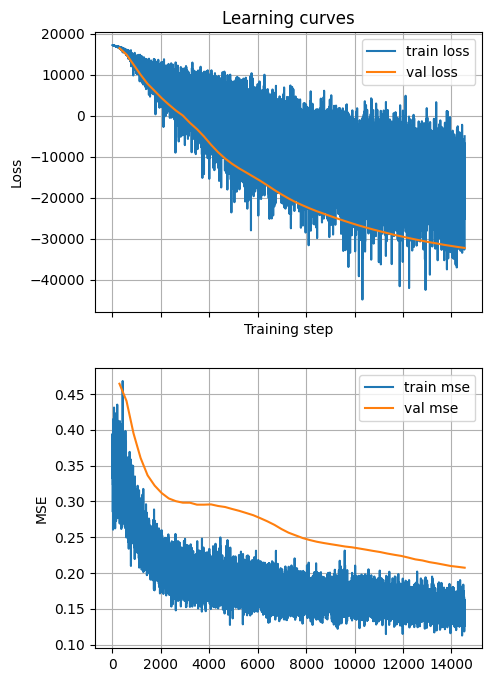

In [61]:
# from train_vae_mnist import train_ae as train_ae

pyro.enable_validation(False)

epochs = 50

n_hidden_features = 1024
n_latent_features = 128
lr = 1e-6


results = []

vae_model = VariationalAutoencoder(
    n_data_features=64 * 64 * 6,
    n_encoder_hidden_features=n_hidden_features,
    n_decoder_hidden_features=n_hidden_features,
    n_latent_features=n_latent_features,  # how many features will be used to represent input
)

loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
loss_fn_args = (vae_model.model, vae_model.guide)
print(f"\n{n_latent_features=}, {n_hidden_features=}, {lr=}")

res = train_ae(
    vae_model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=lr,
    loss_fn=loss_fn,
    loss_fn_args=loss_fn_args,
    # clip_value=500000,
)

epoch:   1%|          | 1/100 [00:10<16:33, 10.04s/it]

Epoch: 0,  Train loss: -15650.3125 Val loss: -32467.678977272728 Train MSE: 0.15213869512081146


epoch:   2%|▏         | 2/100 [00:20<16:30, 10.11s/it]

Epoch: 1,  Train loss: -19665.120738636364 Val loss: -32686.90056818182 Train MSE: 0.1539393812417984


epoch:   3%|▎         | 3/100 [00:30<16:24, 10.15s/it]

Epoch: 2,  Train loss: 1969.7464488636363 Val loss: -32878.275568181816 Train MSE: 0.10725326091051102


epoch:   4%|▍         | 4/100 [00:40<16:01, 10.01s/it]

Epoch: 3,  Train loss: -6637.761363636364 Val loss: -33095.33522727273 Train MSE: 0.1291692703962326


epoch:   5%|▌         | 5/100 [00:50<15:52, 10.03s/it]

Epoch: 4,  Train loss: -13797.698863636364 Val loss: -33282.99715909091 Train MSE: 0.15128357708454132


epoch:   6%|▌         | 6/100 [01:00<15:46, 10.07s/it]

Epoch: 5,  Train loss: -16955.779829545456 Val loss: -33446.97727272727 Train MSE: 0.15494757890701294


epoch:   7%|▋         | 7/100 [01:10<15:29, 10.00s/it]

Epoch: 6,  Train loss: -12285.119318181818 Val loss: -33616.431818181816 Train MSE: 0.13730265200138092


epoch:   8%|▊         | 8/100 [01:20<15:22, 10.02s/it]

Epoch: 7,  Train loss: -5713.978338068182 Val loss: -33781.107954545456 Train MSE: 0.13553443551063538


epoch:   9%|▉         | 9/100 [01:30<15:16, 10.07s/it]

Epoch: 8,  Train loss: -16980.997159090908 Val loss: -33923.244318181816 Train MSE: 0.15947484970092773


epoch:  10%|█         | 10/100 [01:40<15:07, 10.08s/it]

Epoch: 9,  Train loss: -24492.184659090908 Val loss: -34054.90625 Train MSE: 0.14051134884357452


epoch:  11%|█         | 11/100 [01:50<14:52, 10.03s/it]

Epoch: 10,  Train loss: -15996.610795454546 Val loss: -34210.87784090909 Train MSE: 0.16351543366909027


epoch:  12%|█▏        | 12/100 [02:00<14:38,  9.99s/it]

Epoch: 11,  Train loss: -12143.311079545454 Val loss: -34323.798295454544 Train MSE: 0.1504935920238495


epoch:  13%|█▎        | 13/100 [02:10<14:23,  9.92s/it]

Epoch: 12,  Train loss: -5425.434303977273 Val loss: -34443.09090909091 Train MSE: 0.14758192002773285


epoch:  14%|█▍        | 14/100 [02:20<14:18,  9.98s/it]

Epoch: 13,  Train loss: -36505.30397727273 Val loss: -34540.110795454544 Train MSE: 0.16932077705860138


epoch:  15%|█▌        | 15/100 [02:30<14:13, 10.04s/it]

Epoch: 14,  Train loss: -15938.150568181818 Val loss: -34661.23863636364 Train MSE: 0.14716748893260956


epoch:  16%|█▌        | 16/100 [02:40<14:06, 10.07s/it]

Epoch: 15,  Train loss: -10258.163352272728 Val loss: -34782.69602272727 Train MSE: 0.1423436403274536


epoch:  17%|█▋        | 17/100 [02:50<13:56, 10.08s/it]

Epoch: 16,  Train loss: -12750.992897727272 Val loss: -34907.474431818184 Train MSE: 0.1340988129377365


epoch:  18%|█▊        | 18/100 [03:00<13:48, 10.11s/it]

Epoch: 17,  Train loss: -19583.309659090908 Val loss: -34998.51988636364 Train MSE: 0.1375436931848526


epoch:  19%|█▉        | 19/100 [03:10<13:36, 10.09s/it]

Epoch: 18,  Train loss: -18650.217329545456 Val loss: -35099.392045454544 Train MSE: 0.13159430027008057


epoch:  20%|██        | 20/100 [03:20<13:23, 10.04s/it]

Epoch: 19,  Train loss: -28236.988636363636 Val loss: -35205.49715909091 Train MSE: 0.1692267209291458


epoch:  21%|██        | 21/100 [03:30<13:12, 10.03s/it]

Epoch: 20,  Train loss: -15490.65625 Val loss: -35310.34090909091 Train MSE: 0.14815713465213776


epoch:  22%|██▏       | 22/100 [03:40<13:01, 10.02s/it]

Epoch: 21,  Train loss: -24640.50568181818 Val loss: -35373.139204545456 Train MSE: 0.15597806870937347


epoch:  23%|██▎       | 23/100 [03:50<12:47,  9.97s/it]

Epoch: 22,  Train loss: -8618.357954545454 Val loss: -35493.98011363636 Train MSE: 0.1258932501077652


epoch:  24%|██▍       | 24/100 [04:00<12:38,  9.98s/it]

Epoch: 23,  Train loss: -11849.683948863636 Val loss: -35577.96022727273 Train MSE: 0.13559651374816895


epoch:  25%|██▌       | 25/100 [04:10<12:24,  9.92s/it]

Epoch: 24,  Train loss: -29708.482954545456 Val loss: -35664.30397727273 Train MSE: 0.1614004224538803


epoch:  26%|██▌       | 26/100 [04:20<12:10,  9.87s/it]

Epoch: 25,  Train loss: -36867.525568181816 Val loss: -35770.89488636364 Train MSE: 0.16913415491580963


epoch:  27%|██▋       | 27/100 [04:30<12:08,  9.98s/it]

Epoch: 26,  Train loss: -21634.200284090908 Val loss: -35881.86647727273 Train MSE: 0.12468165159225464


epoch:  28%|██▊       | 28/100 [04:40<12:02, 10.04s/it]

Epoch: 27,  Train loss: -19391.492897727272 Val loss: -35934.08522727273 Train MSE: 0.14164911210536957


epoch:  29%|██▉       | 29/100 [04:50<11:53, 10.05s/it]

Epoch: 28,  Train loss: -13940.923295454546 Val loss: -36040.6875 Train MSE: 0.1436655968427658


epoch:  30%|███       | 30/100 [05:00<11:46, 10.10s/it]

Epoch: 29,  Train loss: -25535.877840909092 Val loss: -36125.255681818184 Train MSE: 0.13401037454605103


epoch:  31%|███       | 31/100 [05:11<11:37, 10.10s/it]

Epoch: 30,  Train loss: -20881.59375 Val loss: -36213.295454545456 Train MSE: 0.13964490592479706


epoch:  32%|███▏      | 32/100 [05:21<11:25, 10.07s/it]

Epoch: 31,  Train loss: -12432.494318181818 Val loss: -36298.21590909091 Train MSE: 0.12631626427173615


epoch:  33%|███▎      | 33/100 [05:31<11:14, 10.07s/it]

Epoch: 32,  Train loss: -19519.53125 Val loss: -36388.880681818184 Train MSE: 0.1454167515039444


epoch:  34%|███▍      | 34/100 [05:41<11:05, 10.08s/it]

Epoch: 33,  Train loss: -21423.890625 Val loss: -36450.994318181816 Train MSE: 0.14087128639221191


epoch:  35%|███▌      | 35/100 [05:51<10:54, 10.07s/it]

Epoch: 34,  Train loss: -23821.971590909092 Val loss: -36547.21590909091 Train MSE: 0.14057262241840363


epoch:  36%|███▌      | 36/100 [06:00<10:37,  9.96s/it]

Epoch: 35,  Train loss: -24832.116477272728 Val loss: -36640.69602272727 Train MSE: 0.1515619158744812


epoch:  37%|███▋      | 37/100 [06:11<10:30, 10.00s/it]

Epoch: 36,  Train loss: -25515.664772727272 Val loss: -36732.21590909091 Train MSE: 0.14793957769870758


epoch:  38%|███▊      | 38/100 [06:21<10:23, 10.06s/it]

Epoch: 37,  Train loss: -13301.930397727272 Val loss: -36825.005681818184 Train MSE: 0.13775832951068878


epoch:  39%|███▉      | 39/100 [06:31<10:14, 10.07s/it]

Epoch: 38,  Train loss: -25384.63068181818 Val loss: -36872.74147727273 Train MSE: 0.16194720566272736


epoch:  40%|████      | 40/100 [06:41<10:06, 10.11s/it]

Epoch: 39,  Train loss: 552.9275124289773 Val loss: -36959.10227272727 Train MSE: 0.108491450548172


epoch:  41%|████      | 41/100 [06:52<10:03, 10.22s/it]

Epoch: 40,  Train loss: -20715.997159090908 Val loss: -37029.201704545456 Train MSE: 0.1541440486907959


epoch:  42%|████▏     | 42/100 [07:02<09:53, 10.24s/it]

Epoch: 41,  Train loss: -15938.992897727272 Val loss: -37105.86647727273 Train MSE: 0.12561096251010895


epoch:  43%|████▎     | 43/100 [07:13<09:52, 10.39s/it]

Epoch: 42,  Train loss: -15819.553977272728 Val loss: -37171.764204545456 Train MSE: 0.1370082050561905


epoch:  44%|████▍     | 44/100 [07:23<09:40, 10.37s/it]

Epoch: 43,  Train loss: -12829.839488636364 Val loss: -37258.90909090909 Train MSE: 0.1677982658147812


epoch:  45%|████▌     | 45/100 [07:33<09:28, 10.34s/it]

Epoch: 44,  Train loss: -25697.386363636364 Val loss: -37320.96590909091 Train MSE: 0.16016007959842682


epoch:  46%|████▌     | 46/100 [07:43<09:13, 10.25s/it]

Epoch: 45,  Train loss: -14618.132102272728 Val loss: -37413.985795454544 Train MSE: 0.13544435799121857


epoch:  47%|████▋     | 47/100 [07:53<09:01, 10.21s/it]

Epoch: 46,  Train loss: -15753.318181818182 Val loss: -37470.29261363636 Train MSE: 0.1425357609987259


epoch:  48%|████▊     | 48/100 [08:03<08:48, 10.15s/it]

Epoch: 47,  Train loss: -31386.477272727272 Val loss: -37536.10511363636 Train MSE: 0.14963789284229279


epoch:  49%|████▉     | 49/100 [08:13<08:35, 10.11s/it]

Epoch: 48,  Train loss: -19302.654829545456 Val loss: -37620.97159090909 Train MSE: 0.13543975353240967


epoch:  50%|█████     | 50/100 [08:23<08:23, 10.07s/it]

Epoch: 49,  Train loss: -28786.801136363636 Val loss: -37678.576704545456 Train MSE: 0.15913613140583038


epoch:  51%|█████     | 51/100 [08:33<08:12, 10.04s/it]

Epoch: 50,  Train loss: -23078.132102272728 Val loss: -37739.744318181816 Train MSE: 0.1404508799314499


epoch:  52%|█████▏    | 52/100 [08:44<08:04, 10.09s/it]

Epoch: 51,  Train loss: -39819.59375 Val loss: -37796.451704545456 Train MSE: 0.1724703162908554


epoch:  53%|█████▎    | 53/100 [08:54<07:55, 10.12s/it]

Epoch: 52,  Train loss: -12983.176136363636 Val loss: -37878.232954545456 Train MSE: 0.15999272465705872


epoch:  54%|█████▍    | 54/100 [09:04<07:45, 10.12s/it]

Epoch: 53,  Train loss: -13466.982954545454 Val loss: -37920.54261363636 Train MSE: 0.13193689286708832


epoch:  55%|█████▌    | 55/100 [09:14<07:34, 10.11s/it]

Epoch: 54,  Train loss: -34887.545454545456 Val loss: -37999.119318181816 Train MSE: 0.1668480634689331


epoch:  56%|█████▌    | 56/100 [09:24<07:24, 10.10s/it]

Epoch: 55,  Train loss: -22694.973011363636 Val loss: -38070.68465909091 Train MSE: 0.1517929583787918


epoch:  57%|█████▋    | 57/100 [09:34<07:14, 10.10s/it]

Epoch: 56,  Train loss: -10392.552556818182 Val loss: -38114.94602272727 Train MSE: 0.1401320844888687


epoch:  58%|█████▊    | 58/100 [09:44<07:02, 10.07s/it]

Epoch: 57,  Train loss: -32400.434659090908 Val loss: -38187.556818181816 Train MSE: 0.14601488411426544


epoch:  59%|█████▉    | 59/100 [09:54<06:52, 10.07s/it]

Epoch: 58,  Train loss: -23521.75 Val loss: -38253.036931818184 Train MSE: 0.12742221355438232


epoch:  60%|██████    | 60/100 [10:04<06:40, 10.02s/it]

Epoch: 59,  Train loss: -23611.6875 Val loss: -38322.53125 Train MSE: 0.15712010860443115


epoch:  61%|██████    | 61/100 [10:14<06:32, 10.06s/it]

Epoch: 60,  Train loss: -16177.711647727272 Val loss: -38376.07386363636 Train MSE: 0.11991409212350845


epoch:  62%|██████▏   | 62/100 [10:24<06:21, 10.04s/it]

Epoch: 61,  Train loss: -14626.552556818182 Val loss: -38418.11363636364 Train MSE: 0.1184723973274231


epoch:  63%|██████▎   | 63/100 [10:34<06:09,  9.98s/it]

Epoch: 62,  Train loss: -11403.924005681818 Val loss: -38467.90340909091 Train MSE: 0.10614802688360214


epoch:  64%|██████▍   | 64/100 [10:44<06:00, 10.02s/it]

Epoch: 63,  Train loss: -10875.230823863636 Val loss: -38538.43465909091 Train MSE: 0.11625825613737106


epoch:  65%|██████▌   | 65/100 [10:54<05:51, 10.03s/it]

Epoch: 64,  Train loss: -20072.221590909092 Val loss: -38614.02272727273 Train MSE: 0.148074671626091


epoch:  66%|██████▌   | 66/100 [11:04<05:40, 10.01s/it]

Epoch: 65,  Train loss: -37267.985795454544 Val loss: -38660.139204545456 Train MSE: 0.1547430008649826


epoch:  67%|██████▋   | 67/100 [11:14<05:31, 10.04s/it]

Epoch: 66,  Train loss: -24457.207386363636 Val loss: -38720.860795454544 Train MSE: 0.12147832661867142


epoch:  68%|██████▊   | 68/100 [11:25<05:22, 10.09s/it]

Epoch: 67,  Train loss: -18851.565340909092 Val loss: -38797.96590909091 Train MSE: 0.1339917629957199


epoch:  69%|██████▉   | 69/100 [11:35<05:12, 10.08s/it]

Epoch: 68,  Train loss: -11465.09659090909 Val loss: -38820.91477272727 Train MSE: 0.1345079392194748


epoch:  70%|███████   | 70/100 [11:45<05:01, 10.05s/it]

Epoch: 69,  Train loss: -25105.951704545456 Val loss: -38913.17613636364 Train MSE: 0.14030830562114716


epoch:  71%|███████   | 71/100 [11:55<04:51, 10.06s/it]

Epoch: 70,  Train loss: -14437.46590909091 Val loss: -38956.318181818184 Train MSE: 0.11902707815170288


epoch:  72%|███████▏  | 72/100 [12:05<04:42, 10.08s/it]

Epoch: 71,  Train loss: -18568.654829545456 Val loss: -39010.326704545456 Train MSE: 0.12388211488723755


epoch:  73%|███████▎  | 73/100 [12:15<04:31, 10.06s/it]

Epoch: 72,  Train loss: -5357.967329545455 Val loss: -39078.88352272727 Train MSE: 0.10520925372838974


epoch:  74%|███████▍  | 74/100 [12:25<04:21, 10.05s/it]

Epoch: 73,  Train loss: -28331.866477272728 Val loss: -39147.03125 Train MSE: 0.14665500819683075


epoch:  75%|███████▌  | 75/100 [12:35<04:10, 10.02s/it]

Epoch: 74,  Train loss: -32431.946022727272 Val loss: -39186.99147727273 Train MSE: 0.14830218255519867


epoch:  76%|███████▌  | 76/100 [12:45<03:59,  9.97s/it]

Epoch: 75,  Train loss: -27351.05681818182 Val loss: -39237.119318181816 Train MSE: 0.1386767029762268


epoch:  77%|███████▋  | 77/100 [12:54<03:47,  9.90s/it]

Epoch: 76,  Train loss: -15293.295454545454 Val loss: -39298.525568181816 Train MSE: 0.1366480439901352


epoch:  78%|███████▊  | 78/100 [13:04<03:38,  9.92s/it]

Epoch: 77,  Train loss: -20904.285511363636 Val loss: -39371.93465909091 Train MSE: 0.12835776805877686


epoch:  79%|███████▉  | 79/100 [13:15<03:30, 10.04s/it]

Epoch: 78,  Train loss: -24273.321022727272 Val loss: -39412.494318181816 Train MSE: 0.12489118427038193


epoch:  80%|████████  | 80/100 [13:25<03:21, 10.08s/it]

Epoch: 79,  Train loss: -9476.387073863636 Val loss: -39474.73863636364 Train MSE: 0.1275501400232315


epoch:  81%|████████  | 81/100 [13:35<03:11, 10.06s/it]

Epoch: 80,  Train loss: -18304.002840909092 Val loss: -39534.485795454544 Train MSE: 0.1405177265405655


epoch:  82%|████████▏ | 82/100 [13:45<03:01, 10.06s/it]

Epoch: 81,  Train loss: -18836.65625 Val loss: -39553.994318181816 Train MSE: 0.1305396407842636


epoch:  83%|████████▎ | 83/100 [13:55<02:52, 10.12s/it]

Epoch: 82,  Train loss: -14613.928977272728 Val loss: -39622.47727272727 Train MSE: 0.12167838215827942


epoch:  84%|████████▍ | 84/100 [14:05<02:42, 10.13s/it]

Epoch: 83,  Train loss: -28792.241477272728 Val loss: -39675.25284090909 Train MSE: 0.13861310482025146


epoch:  85%|████████▌ | 85/100 [14:15<02:31, 10.11s/it]

Epoch: 84,  Train loss: -21442.282670454544 Val loss: -39745.920454545456 Train MSE: 0.1261742264032364


epoch:  86%|████████▌ | 86/100 [14:25<02:20, 10.03s/it]

Epoch: 85,  Train loss: -23502.720170454544 Val loss: -39787.50284090909 Train MSE: 0.12017697840929031


epoch:  87%|████████▋ | 87/100 [14:35<02:10, 10.00s/it]

Epoch: 86,  Train loss: -14058.46875 Val loss: -39853.34659090909 Train MSE: 0.12092971801757812


epoch:  88%|████████▊ | 88/100 [14:45<01:59,  9.96s/it]

Epoch: 87,  Train loss: -27806.258522727272 Val loss: -39893.15625 Train MSE: 0.14280086755752563


epoch:  89%|████████▉ | 89/100 [14:55<01:49,  9.97s/it]

Epoch: 88,  Train loss: -31895.74431818182 Val loss: -39959.17613636364 Train MSE: 0.15367403626441956


epoch:  90%|█████████ | 90/100 [15:05<01:39,  9.94s/it]

Epoch: 89,  Train loss: -22135.085227272728 Val loss: -39992.079545454544 Train MSE: 0.1263965219259262


epoch:  91%|█████████ | 91/100 [15:15<01:29,  9.96s/it]

Epoch: 90,  Train loss: -30609.735795454544 Val loss: -40034.161931818184 Train MSE: 0.15768440067768097


epoch:  92%|█████████▏| 92/100 [15:25<01:19,  9.96s/it]

Epoch: 91,  Train loss: -16834.768465909092 Val loss: -40094.3125 Train MSE: 0.12193699926137924


epoch:  93%|█████████▎| 93/100 [15:35<01:09,  9.96s/it]

Epoch: 92,  Train loss: -25801.31818181818 Val loss: -40161.40625 Train MSE: 0.14720474183559418


epoch:  94%|█████████▍| 94/100 [15:45<00:59,  9.99s/it]

Epoch: 93,  Train loss: -13459.193181818182 Val loss: -40216.880681818184 Train MSE: 0.1397138237953186


epoch:  95%|█████████▌| 95/100 [15:55<00:49,  9.99s/it]

Epoch: 94,  Train loss: -25614.085227272728 Val loss: -40242.87784090909 Train MSE: 0.14053453505039215


epoch:  96%|█████████▌| 96/100 [16:05<00:40, 10.00s/it]

Epoch: 95,  Train loss: -28651.0625 Val loss: -40300.23863636364 Train MSE: 0.15688228607177734


epoch:  97%|█████████▋| 97/100 [16:15<00:30, 10.04s/it]

Epoch: 96,  Train loss: -36100.56534090909 Val loss: -40348.900568181816 Train MSE: 0.13613097369670868


epoch:  98%|█████████▊| 98/100 [16:25<00:20, 10.14s/it]

Epoch: 97,  Train loss: -12264.09375 Val loss: -40406.400568181816 Train MSE: 0.12024914473295212


epoch:  99%|█████████▉| 99/100 [16:35<00:10, 10.11s/it]

Epoch: 98,  Train loss: -13198.494318181818 Val loss: -40473.51136363636 Train MSE: 0.12786228954792023


epoch: 100%|██████████| 100/100 [16:46<00:00, 10.06s/it]

Epoch: 99,  Train loss: -24003.573863636364 Val loss: -40506.610795454544 Train MSE: 0.125327929854393


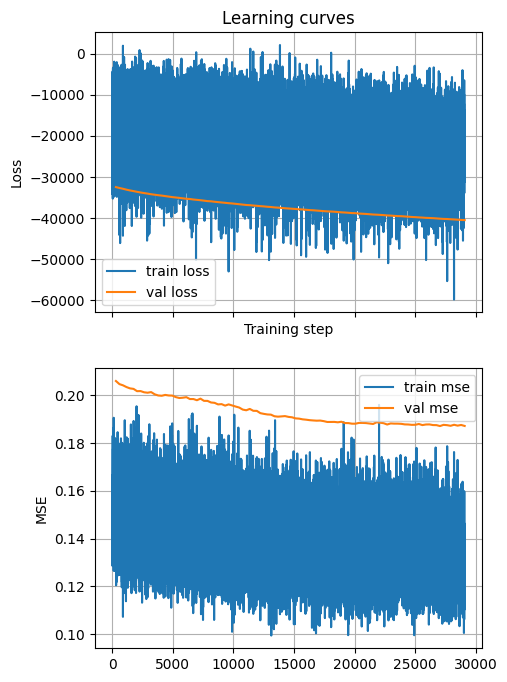

In [70]:
epochs = 100
res = train_ae(
    vae_model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=lr,
    loss_fn=loss_fn,
    loss_fn_args=loss_fn_args,
    # clip_value=500000,
)

In [57]:
import torch
from sklearn.metrics import mean_squared_error

def evaluate(model, test_loader):
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model
    mse = 0.0
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            reconstructions = model(inputs)
            mse += mean_squared_error(
                inputs.cpu().view(inputs.shape[0], -1),
                reconstructions.cpu().view(reconstructions.shape[0], -1),
            )
    return mse / len(test_loader)


In [73]:
print("Typical test set MSE: ", evaluate(vae_model, test_typical_loader))

Typical test set MSE:  0.11771559858685927


In [74]:
print("Novel test set MSE: ", evaluate(vae_model, test_novel_loader))

Novel test set MSE:  0.11743828208987103


In [19]:
def display_reproductions(model, loader, n=8):
    reconstructions = []
    inputs = []
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model

    with torch.no_grad():
        for i, (input, _) in enumerate(loader):
            if i >= n:
                break
            input = input.to(device)  # Move input to the same device as the model
            inputs.append(input.cpu())  # Store the original input on CPU for plotting
            reconstructions.append(model(input).cpu())  # Move the output to CPU for plotting

    fig, axes = plt.subplots(2, n, figsize=(20, 5))
    for i in range(n):
        rec = reconstructions[i][0].squeeze(0)
        rec = rec[:3, :, :]
        rec = np.transpose(rec, (1, 2, 0))
        rec = np.take(rec, [2, 0, 1], axis=2)

        img = inputs[i][0].squeeze(0)
        img = img[:3, :, :]
        img = np.transpose(img, (1, 2, 0))
        img = np.take(img, [2, 0, 1], axis=2)

        axes[0, i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
        axes[1, i].imshow(np.interp(rec, (rec.min(), rec.max()), (0, 1)))
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()


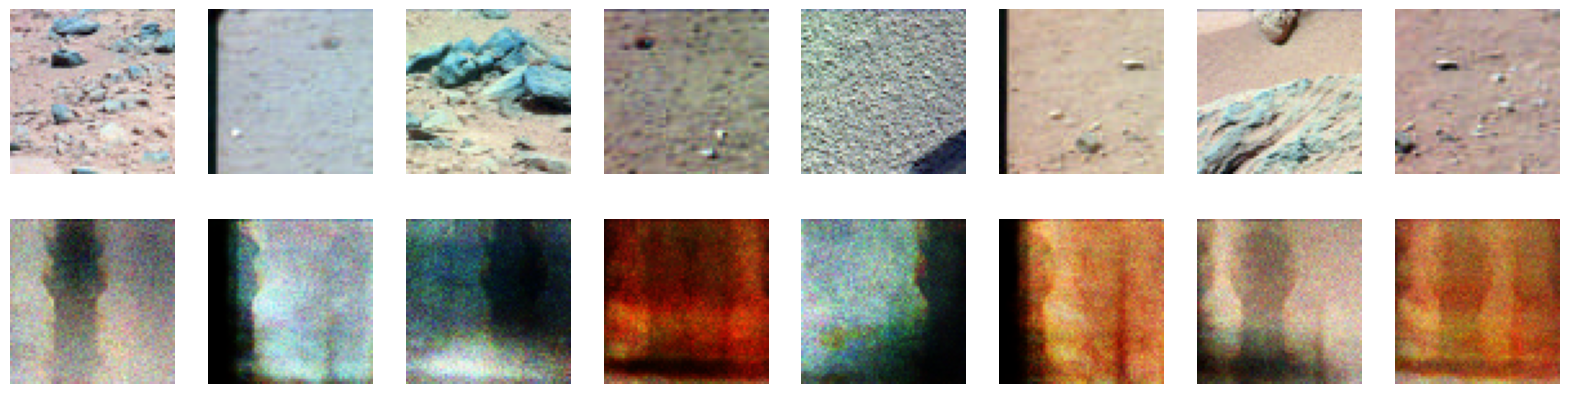

In [71]:
display_reproductions(vae_model, test_typical_loader, n=8)

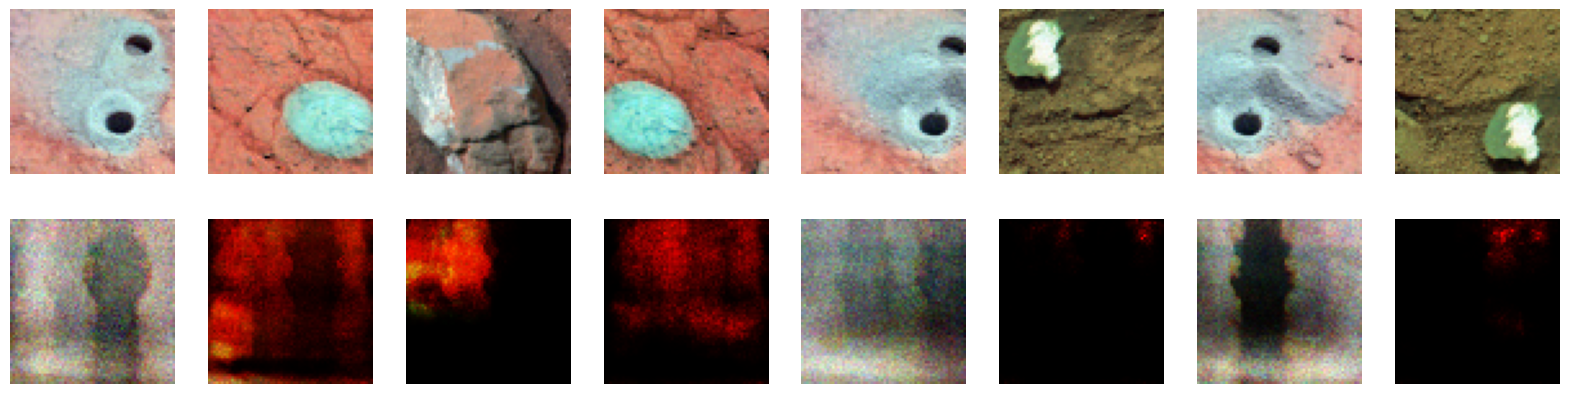

In [72]:
display_reproductions(vae_model, test_novel_loader, n=8)

In [75]:
import torch

# save the model
torch.save(vae_model.state_dict(), "vae_model-100-epoch.pth")

In [68]:
n_data_features = 64*64*6
# load the model
vae_model_loaded = VariationalAutoencoder(
    n_data_features=n_data_features,
    n_encoder_hidden_features=n_hidden_features,
    n_decoder_hidden_features=n_hidden_features,
    n_latent_features=n_latent_features,  # how many features will be used to represent input
)
vae_model_loaded.load_state_dict(torch.load("vae_model-50-epoch.pth"))

<All keys matched successfully>

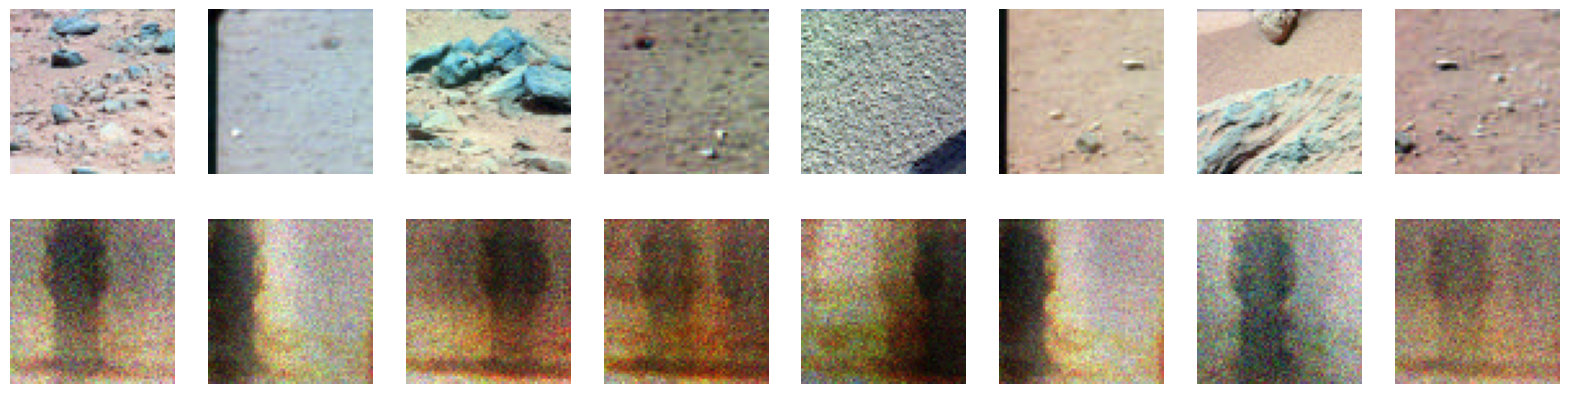

In [69]:
display_reproductions(vae_model_loaded, test_typical_loader, n=8)

## Different VAE implementation

In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
# import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith("1.9.1")
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = "CI" in os.environ

# Define the image dimensions
image_height, image_width, num_channels = 64, 64, 6
n_data_features = image_height * image_width * num_channels


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, n_data_features)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.n_data_features = n_data_features

    def forward(self, z):
        # define the forward computation on the latent z
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc21(hidden))
        # if torch.isnan(loc_img).any():
        #     print("NaN detected in Decoder output")
        # else:
        #     print("No NaN detected in Decoder output")
        return loc_img


class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(n_data_features, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.n_data_features = n_data_features

    def forward(self, x):
        x = x.reshape(-1, self.n_data_features)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))  # Ensure z_scale is always positive
        # if torch.isnan(z_loc).any() or torch.isnan(z_scale).any():
        #     print("NaN detected in Encoder output")
        # else:
        #     print("No NaN detected in Encoder output")
        return z_loc, z_scale


class VAE(nn.Module):
    n_data_features: int

    def __init__(
        self,
        z_dim=50,
        hidden_dim=400,
        use_cuda=False,
        n_data_features: int = n_data_features,
    ):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, n_data_features)
        self.decoder = Decoder(z_dim, hidden_dim, n_data_features)
        self.n_data_features = n_data_features

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img).to_event(1),
                obs=x.reshape(-1, self.n_data_features),
            )

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        if torch.isnan(loc_img).any():
            print("NaN detected in reconstructed image")
        return loc_img

AssertionError: 

In [42]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from tqdm.auto import tqdm, trange

# assert pyro.__version__.startswith("1.9.1")
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = "CI" in os.environ

# Define the image dimensions
image_height, image_width, num_channels = 64, 64, 6
n_data_features = image_height * image_width * num_channels


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, n_data_features)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.n_data_features = n_data_features

    def forward(self, z):
        # define the forward computation on the latent z
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img


class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(n_data_features, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.n_data_features = n_data_features

    def forward(self, x):
        x = x.reshape(-1, self.n_data_features)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))  # Ensure z_scale is always positive
        return z_loc, z_scale


class VAE(nn.Module):
    n_data_features: int

    def __init__(
        self,
        z_dim=50,
        hidden_dim=400,
        use_cuda=False,
        n_data_features: int = n_data_features,
    ):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, n_data_features)
        self.decoder = Decoder(z_dim, hidden_dim, n_data_features)
        self.n_data_features = n_data_features

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img).to_event(1),
                obs=x.reshape(-1, self.n_data_features),
            )

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        if torch.isnan(loc_img).any():
            print("NaN detected in reconstructed image")
        return loc_img


def train(svi, train_loader, model: VAE, use_cuda=False, epochs=10):
    train_metrics = {
        "loss": [],
        "step": [],
    }
    global_step = 0

    for epoch in trange(epochs, desc="epoch"):
        model.train()
        pbar = tqdm(train_loader, desc="step", leave=False)
        for x, _ in pbar:
            if use_cuda:
                x = x.cuda()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            step_loss = svi.step(x)
            train_metrics["loss"].append(step_loss / len(x))
            train_metrics["step"].append(global_step)
            global_step += 1
            pbar.set_postfix(loss=step_loss / len(x))
        pbar.close()

    plot_metrics(train_metrics)
    return train_metrics


def evaluate(svi, test_loader, model: VAE, use_cuda=False):
    test_loss = 0.0
    model.eval()
    for x, _ in test_loader:
        if use_cuda:
            x = x.cuda()
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test


def plot_metrics(train_metrics):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1.plot(train_metrics["step"], train_metrics["loss"], label="train loss")
    ax1.set_xlabel("Training step")
    ax1.set_ylabel("Loss")
    ax1.set_title("Learning curves")
    ax1.grid()
    ax1.legend()
    plt.show()

epoch: 100%|██████████| 10/10 [01:31<00:00,  9.13s/it]


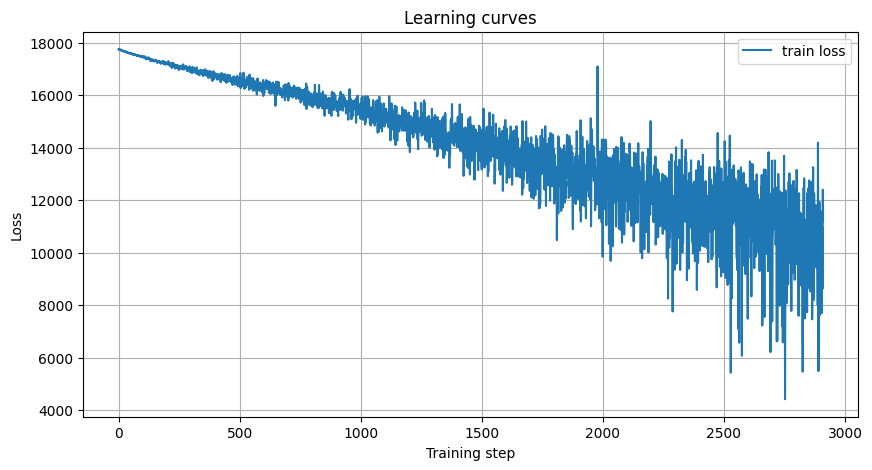

test loss: 13065.05104934022


In [43]:
# Run options
LEARNING_RATE = 1.0e-6
USE_CUDA = True
NUM_EPOCHS = 10
TEST_FREQUENCY = 5
# train_loader, val_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA, n_data_features=64 * 64 * 6)

adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_metrics = total_epoch_loss_train = train(svi, train_loader, vae, use_cuda=USE_CUDA, epochs=NUM_EPOCHS)

test_typical_loss = evaluate(svi, test_typical_loader, vae, use_cuda=USE_CUDA)
print(f"test loss: {test_typical_loss}")

In [39]:
def display_reproductions_2(model: VAE, loader, n=8):
    reconstructions = []
    inputs = []
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model

    with torch.no_grad():
        for i, (input, _) in enumerate(loader):
            if i >= n:
                break
            input = input.to(device)  # Move input to the same device as the model
            inputs.append(input.cpu())  # Store the original input on CPU for plotting
            reconstructions.append(model.reconstruct_img(input).cpu())  # Move the output to CPU for plotting

    fig, axes = plt.subplots(2, n, figsize=(20, 5))
    for i in range(n):
        rec = reconstructions[i][0].squeeze(0)
        rec = rec.view(6, 64, 64)
        rec = rec[:3, :, :]
        rec = np.transpose(rec, (1, 2, 0))
        rec = np.take(rec, [2, 0, 1], axis=2)

        img = inputs[i][0].squeeze(0)
        img = img[:3, :, :]
        img = np.transpose(img, (1, 2, 0))
        img = np.take(img, [2, 0, 1], axis=2)

        axes[0, i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
        axes[1, i].imshow(np.interp(rec, (rec.min(), rec.max()), (0, 1)))
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()


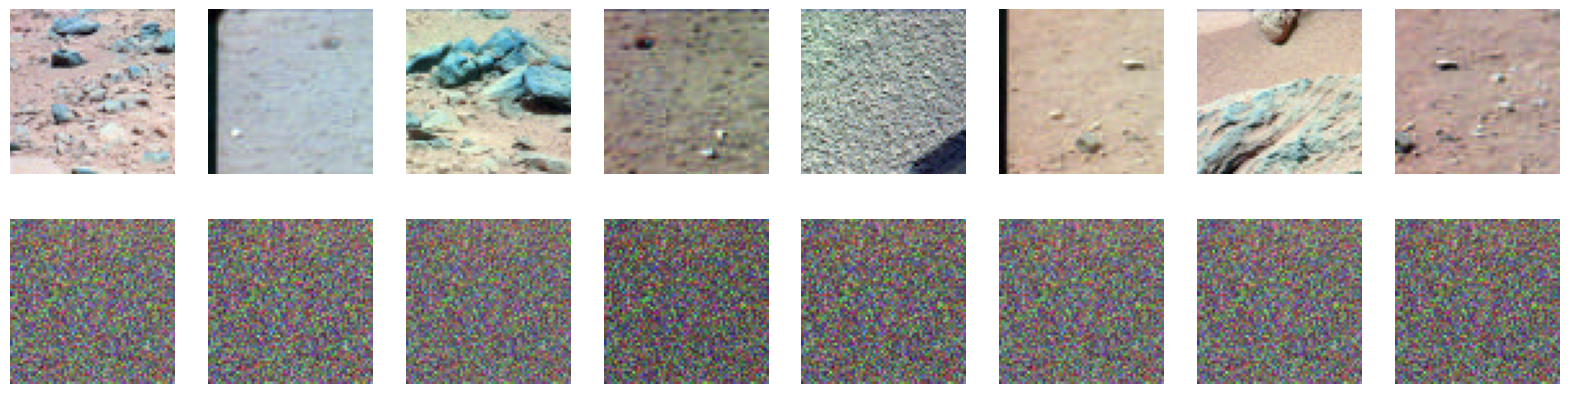

In [44]:
display_reproductions_2(vae, test_typical_loader, n=8)